## 오토인코더
오토인코더는 라벨 없이 원하는 출력값을 생성하는 모델이다. 따라서 모델의 파라메타들을 학습하기 위해 라벨을 사용하지 않는 비지도 학습(unsupervised learning)에 속한다. 오토인코더는 많은 연구에 기반이 되는 기본적인 비지도 학습 모델 중 하나다.

### 1. 라이브러리 호출 및 연산 타입 확인

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# GPU VS CPU
#현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda:0 is available


### 2. MNIST 데이터 불러오기

In [3]:
dataset = torchvision.datasets.MNIST('./data',download=True,train=True,transform=transforms.ToTensor())
trainloader= torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 57734260.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102919026.19it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20085126.13it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17754453.65it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 3. 오토인코더 모델 생성

In [10]:
class Flatten(torch.nn.Module): #4D -> 2D 로 계산하기
  def forward(self,x):
    batch_size = x.shape[0]
    return x.view(batch_size,-1) #(배치수, 채널수,이미지 높이,이미지 너비) -> (배치수, 채널수*이미지 너비*이미지 높이)

class Unflatten(nn.Module): #2D->4D로 계산하기
  def __init__(self,k):
    super(Unflatten,self).__init__()
    self.k = k

  def forward(self,x):
    s = x.size()

    #벡터 사이즈 = 채널수*이미지 너비*이미지 높이
    #벡터 사이즈 = 채널수*이미지 사이즈**2
    #이미지 사이즈 = (벡터 사이즈//채널 수)**.5
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0],self.k,feature_size,feature_size) #(배치수,채널수*이미지 너비*이미지 높이) -> (배치 수, 채널 수, 이미지 높이, 이미지 너비)

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder,self).__init__()

    k=16
    self.encoder = nn.Sequential(
        nn.Conv2d(1,k,3,stride=2),
        nn.ReLU(),
        nn.Conv2d(k,2*k,3,stride=2),
        nn.ReLU(),
        nn.Conv2d(2*k,4*k,3,stride=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(1024,10),
        nn.ReLU()
    )
    #ConvTranspose2d
    #입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출한다.
    #출력 된 벡터는 행렬 형태로 변환한다.
    self.decoder = nn.Sequential(
        nn.Linear(10,1024),
        nn.ReLU(),
        Unflatten(4*k),
        nn.ConvTranspose2d(4*k,2*k,3,stride=1), #(입력 채널 수, 출력 채널 수, 필터 크기, stride)
        nn.ReLU(),
        nn.ConvTranspose2d(2*k,k,3,stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(k,1,3,stride=2,output_padding=1)
    )

  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [11]:
model = Autoencoder().to(device)

### 4. 시각화 함수 만들기

In [6]:
def normalize_output(img):
  img = (img-img.min())/(img.max()-img.min())
  return img
def check_plot():
  with torch.no_grad():
    for data in trainloader:
      inputs = data[0].to(device)
      outputs = model(inputs)

      input_samples = inputs.permute(0,2,3,1).cpu().numpy() #원래 이미지
      reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() #생성 이미지
      break #배치 하나만 받고 for문 종료

  columns = 10 #시각화 전체 너비
  rows = 5 #시각화 전체 높이

  fig = plt.figure(figsize=(8,4)) #figure 선언

  #원래 이미지 배치 크기 만큼 보여주기
  for i in range(1, columns*rows+1):
    img = input_samples[i-1]
    fig.add_subplot(rows,columns,i)
    plt.imshow(img.squeeze())
    plt.axis('off')
  plt.show()

  #생성 이미지 배치 크기 만큼 보여주기
  fig = plt.figure(figsize=(8,4)) #figure 선언

  for i in range(1, columns*rows+1):
    img = reconstructed_samples[i-1]
    fig.add_subplot(rows,columns,i)
    plt.imshow(img.squeeze())
    plt.axis('off')
  plt.show()


### 5. 손실 함수 및 최적화 방법 정의

In [12]:
criterion = nn.MSELoss() #MSE 사용
optimizer = optim.Adam(model.parameters(),lr=1e-4)

### 6. 오토인코더 학습하기

[1] loss: 0.069


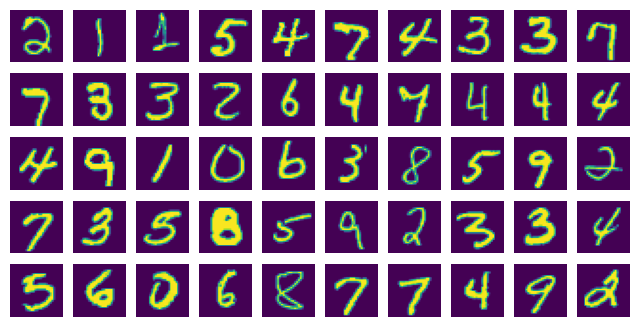

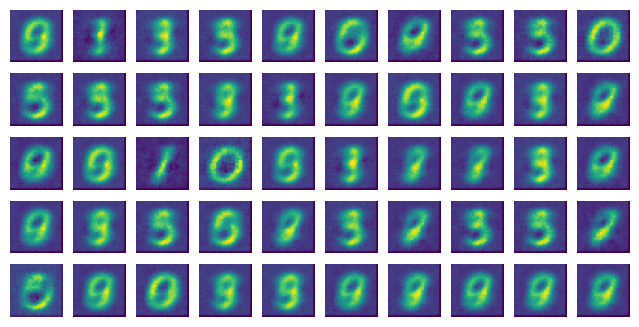

[11] loss: 0.036


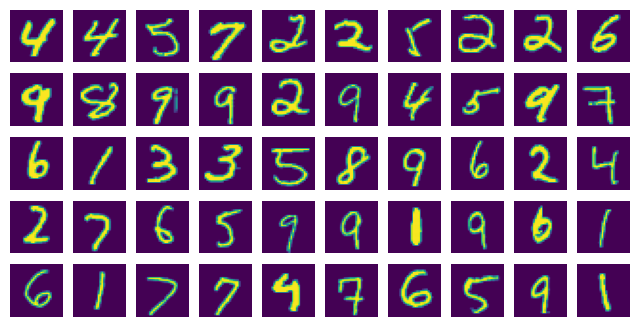

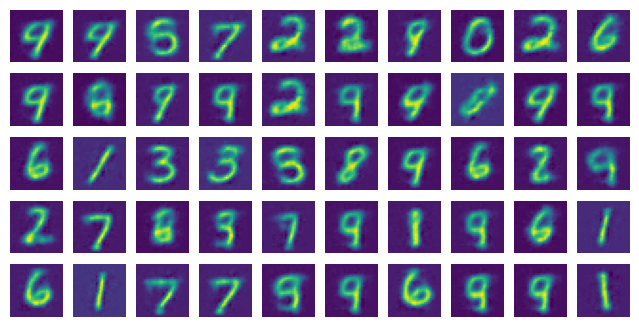

[21] loss: 0.034


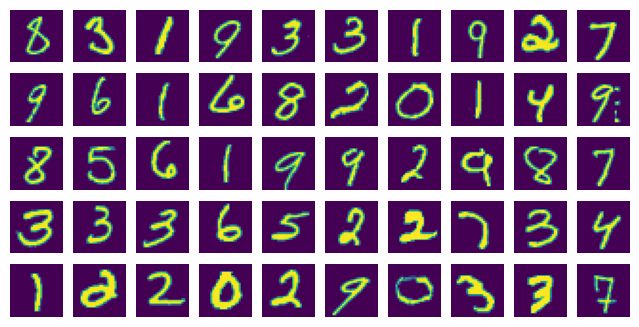

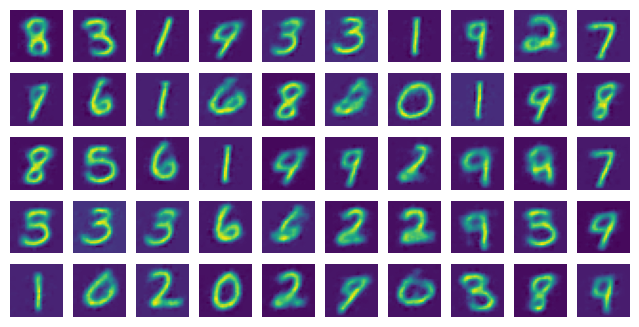

In [14]:
for epoch in range(21):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = criterion(inputs,outputs) #라벨 대신 입력 이미지와 출력 이미지를 비교

    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  cost = running_loss/len(trainloader)

  if epoch%10 ==0:
    print('[%d] loss: %.3f' %(epoch+1,cost))
    check_plot()